# Three subnetwork model for Segmentation Quality prediction - Skin Lesion Dataset

## Load and Preprocess data

In [1]:
#Check the current working directory
import os
os.getcwd()
#To changr the current working directory: os.chdir('[pa

'/home/invited/Desktop/CARS_2024'

In [1]:
# Preprocess the input images to the sub-branches
def load_and_preprocess_seg_map(seg_map_path):
    # Load the segmentation map from the provided path
    seg_map = cv2.imread(seg_map_path, cv2.IMREAD_GRAYSCALE)

    target_size = (300, 300)  # Adjust to desired size
    seg_map = cv2.resize(seg_map, target_size)
    # Ensure that the data type is appropriate (e.g., float32)
    seg_map = seg_map.astype(np.float32)
    seg_map=seg_map/255.0
    # Return the preprocessed segmentation map
    return seg_map

def load_and_preprocess_uncertainty_map(uncertainity_map_path):
    # Load the segmentation map from the provided path
    uncertainity_map = cv2.imread(uncertainity_map_path, cv2.IMREAD_GRAYSCALE)
    target_size = (300, 300)  # Adjust to  desired size
    uncertainity_map = cv2.resize(uncertainity_map, target_size)
    uncertainity_map= uncertainity_map.astype(np.float32)
    uncertainity_map= uncertainity_map/255.0
    # Return the preprocessed segmentation map
    return uncertainity_map

def load_and_preprocess_original_image(original_image_path):
    # Load the segmentation map from the provided path
    original_image= cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)
    target_size = (300, 300)  # Adjust to  desired size
    original_image = cv2.resize(original_image, target_size)
    original_image= original_image.astype(np.float32)
    original_image= original_image/255.0
    # Return the preprocessed segmentation map
    return original_image

In [ ]:
import cv2
import os
import numpy as np
from keras.models import load_model
from sklearn.model_selection import train_test_split
import pandas as pd  # Import the pandas library

# Step 1: Load and Preprocess Data
original_image_dir= '/home/invited/Desktop/ISBI2024/Val/images2'
seg_maps_dir = '/home/invited/Desktop/ISBI2024/ensemble/predictions/val/prediction_segmentation_0.2'
uncertainty_maps_dir = '/home/invited/Desktop/ISBI2024/ensemble/val/confidence'

# List files in the directories
original_image_files= os.listdir(original_image_dir)
seg_map_files = os.listdir(seg_maps_dir)
uncertainty_map_files = os.listdir(uncertainty_maps_dir)
# Load Dice coefficients from the Excel file
dice_coefficients_df = pd.read_excel('/home/invited/Desktop/ISBI2024/ensemble/val_dice_scores.xlsx')  # Adjust the path as needed

# Sort the files to ensure they match
original_image_files.sort()
seg_map_files.sort()
uncertainty_map_files.sort()

# Initialize empty lists to store data
X_original_image=[]
X_seg_maps = []
X_uncertainty_maps = []
y_dice_coefficients = []


# Assuming the filenames are in the first column (index 0) of the Excel file
image_names = dice_coefficients_df.iloc[:, 0].tolist()  # Extract the filenames as a list
dice_scores = dice_coefficients_df.iloc[:, 1].tolist()  # Extract the Dice scores as a list

# Create a dictionary to map filenames to Dice coefficients
dice_coefficient_dict = dict(zip(image_names, dice_scores))

# Processing the pairs of segmentation maps and uncertainty maps
for image_file,seg_file, uncertainty_file in zip(original_image_files,seg_map_files, uncertainty_map_files):
    # Load and preprocess original images, segmentation map and uncertainty map
    
    seg_map = load_and_preprocess_seg_map(os.path.join(seg_maps_dir, seg_file))
    uncertainty_map = load_and_preprocess_uncertainty_map(os.path.join(uncertainty_maps_dir, uncertainty_file))
    original_image=load_and_preprocess_original_image(os.path.join(original_image_dir,image_file))
    # Extract Dice coefficient for this pair using the dictionary
    dice_coefficient = dice_coefficient_dict.get(seg_file, 0.0)  # Default to 0.0 if not found
    #print(seg_file,uncertainty_file,dice_coefficient)
    # Append data to the lists
    X_original_image.append(original_image)
    X_seg_maps.append(seg_map)
    X_uncertainty_maps.append(uncertainty_map)
    y_dice_coefficients.append(dice_coefficient)

# Convert lists to numpy arrays
X_original_image= np.array(X_original_image)
X_seg_maps = np.array(X_seg_maps)
X_uncertainty_maps = np.array(X_uncertainty_maps)
y_dice_coefficients = np.array(y_dice_coefficients)

# Split data into training and validation sets
X_train_original,X_val_original,X_train_seg, X_val_seg, X_train_uncertainty, X_val_uncertainty, y_train, y_val = train_test_split(
    X_original_image,X_seg_maps, X_uncertainty_maps, y_dice_coefficients, test_size=0.2, random_state=42
)



2023-12-13 15:30:27.090820: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 15:30:27.114980: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 15:30:27.115001: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 15:30:27.115018: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 15:30:27.120169: I tensorflow/core/platform/cpu_feature_g

# Three input Model Definition

In [2]:
from keras.src.layers.pooling.max_pooling2d import MaxPool2D
from keras.layers import Input, Conv2D, Flatten, Dense, concatenate
from keras.models import Model
import numpy as np
from tensorflow.keras.layers import Dropout


height=300
width=300
channels=1

# Define the input shape for segmentation maps and uncertainty maps
input_shape = (height, width, channels)  # Adjust these dimensions based on the data

# Create Siamese twin branches
original_input= Input(shape=input_shape, name='originalimage_input')
segmentation_input = Input(shape=input_shape, name='segmentation_input')
uncertainty_input = Input(shape=input_shape, name='uncertainty_input')

# Shared Convolutional block 1
conv1 = Conv2D(64, (3, 3), activation='relu')(original_input)
conv1=MaxPool2D(pool_size=(2, 2))(conv1)
conv1=Conv2D(64,(3,3),activation='relu')(conv1)
conv1=MaxPool2D(pool_size=(2, 2))(conv1)
conv1=Conv2D(32,(3,3),activation='relu')(conv1)
conv1=MaxPool2D(pool_size=(2, 2))(conv1)
conv1=Conv2D(32,(3,3),activation='relu')(conv1)
conv1=MaxPool2D(pool_size=(2, 2))(conv1)
conv1=Conv2D(16,(3,3),activation='relu')(conv1)

# Shared Convolutional block 2
conv2 = Conv2D(64, (3, 3), activation='relu')(uncertainty_input)
conv2=MaxPool2D(pool_size=(2, 2))(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv2)
conv2=MaxPool2D(pool_size=(2, 2))(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu')(conv2)
conv2=MaxPool2D(pool_size=(2, 2))(conv2)
conv2 = Conv2D(32, (3, 3), activation='relu')(conv2)
conv2=MaxPool2D(pool_size=(2, 2))(conv2)
conv2 = Conv2D(16, (3, 3), activation='relu')(conv2)

# Shared Convolutional block 3
conv3 = Conv2D(64, (3, 3), activation='relu')(segmentation_input)
conv3=MaxPool2D(pool_size=(2, 2))(conv3)
conv3=Conv2D(64,(3,3),activation='relu')(conv3)
conv3=MaxPool2D(pool_size=(2, 2))(conv3)
conv3=Conv2D(32,(3,3),activation='relu')(conv3)
conv3=MaxPool2D(pool_size=(2, 2))(conv3)
conv3=Conv2D(32,(3,3),activation='relu')(conv3)
conv3=MaxPool2D(pool_size=(2, 2))(conv3)
conv3=Conv2D(16,(3,3),activation='relu')(conv3)

# Merge the twin branches
merged = concatenate([conv1, conv2,conv3])

# Add fully connected layers for regression
flatten = Flatten()(merged)
dense1 = Dense(128, activation='relu')(flatten)
#dense1 = Dense(128, activation='relu')(dense1)
dense1 = Dense(128, activation='relu')(dense1)
#dropout_rate = 0.5
#dropout1 = Dropout(rate=dropout_rate)(dense1)

output = Dense(1, activation='linear', name='output')(dense1)  # Linear activation for regression

# Create the multi-input prediction model
model = Model(inputs=[original_input,segmentation_input, uncertainty_input], outputs=output)

# Compile the model with an appropriate loss function (e.g., Mean Squared Error) and optimizer
model.compile(loss='MeanSquaredError', optimizer='adam')

# Print a summary of the model architecture
model.summary()


2023-12-13 15:30:41.132758: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-13 15:30:41.156784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 15:30:41.156802: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 15:30:41.156823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 15:30:41.161704: I tensorflow/core/platform/cpu_feature_g

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 originalimage_input (Input  [(None, 300, 300, 1)]        0         []                            
 Layer)                                                                                           
                                                                                                  
 uncertainty_input (InputLa  [(None, 300, 300, 1)]        0         []                            
 yer)                                                                                             
                                                                                                  
 segmentation_input (InputL  [(None, 300, 300, 1)]        0         []                            
 ayer)                                                                                        

                                                                                                  
 dense (Dense)               (None, 128)                  1204352   ['flatten[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 output (Dense)              (None, 1)                    129       ['dense_1[0][0]']             
                                                                                                  
Total params: 1430705 (5.46 MB)
Trainable params: 1430705 (5.46 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


2023-12-13 15:30:42.357426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 15:30:42.357488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 15:30:42.714016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Train the model With data augmentation

In [6]:

import os
import numpy as np
import pandas as pd
from keras.layers import Input, Conv2D, Flatten, Dense, concatenate
from keras.models import Model
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Data Augmentation
batch_size = 20
epochs =20

original_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

seg_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

uncertainty_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
X_train_original = X_train_original.reshape( -1,height, width, channels)
X_train_seg = X_train_seg.reshape( -1,height, width, channels)
X_train_uncertainty = X_train_uncertainty.reshape(-1,height, width, channels)

X_val_original = X_val_original.reshape(-1, height, width, channels)
X_val_seg = X_val_seg.reshape(-1, height, width, channels)
X_val_uncertainty = X_val_uncertainty.reshape(-1, height, width, channels)

# Fit the data generators
original_datagen.fit(X_train_original)
seg_datagen.fit(X_train_seg)
uncertainty_datagen.fit(X_train_uncertainty)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with data augmentation and validation
history = model.fit(
    [X_train_original ,X_train_seg, X_train_uncertainty],
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([X_val_original ,X_val_seg, X_val_uncertainty], y_val),
    verbose=1,
    callbacks=[early_stopping]
)


Epoch 1/20


2023-12-13 15:23:55.351737: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-13 15:23:55.818524: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 15:23:56.531912: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-13 15:23:56.750336: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2ce3fd7930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-13 15:23:56.750351: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-12-13 15:23:56.753301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-13 15:23:56.819210: I ./tensorflow/compiler/jit/device_comp

101/101 [==============================] - 12s 65ms/step - loss: 0.0627 - val_loss: 0.0413
Epoch 2/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0168 - val_loss: 0.0151
Epoch 3/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 4/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0130 - val_loss: 0.0131
Epoch 5/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0092 - val_loss: 0.0125
Epoch 6/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0092 - val_loss: 0.0114
Epoch 7/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0078 - val_loss: 0.0136
Epoch 8/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0065 - val_loss: 0.0153
Epoch 9/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0068 - val_loss: 0.0117
Epoch 10/20
101/101 [==============================] - 6s 55ms/step - loss: 0.0051 - val_loss: 0.0114

# Plot the Learning Curve

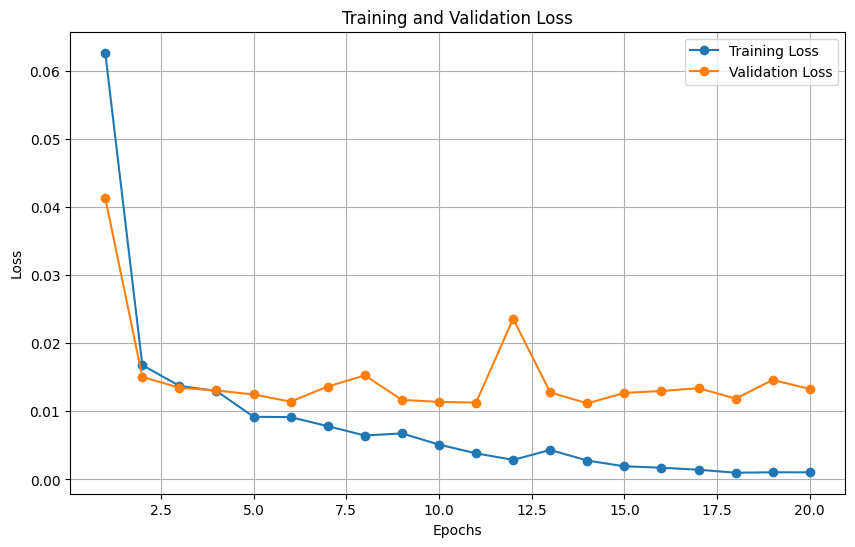

In [7]:
# Plot the training curve
import matplotlib.pyplot as plt
# Extract training loss and validation loss from history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
num_epochs=20
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Optionally, save the trained model weights
model.save_weights('Models/ensemble_confidence.h5')


In [3]:
model.load_weights('Models/ensemble_confidence.h5')

## Test the model

In [4]:
import cv2
import os
import numpy as np



# Define the path to the folder containing test images

test_images_dir = '/home/invited/Desktop/ISBI2024/Test/images2'
seg_test_dir= '/home/invited/Desktop/ISBI2024/ensemble/predictions/test/prediction_segmentation_0.2'
un_test_dir='/home/invited/Desktop/ISBI2024/ensemble/Test/confidence'
# Initialize empty lists to store data
X_test_orig=[]
X_test_seg_maps = []
X_test_uncertainty_maps = []

# Iterate over the test images
for image_file in os.listdir(seg_test_dir):
    seg_path = os.path.join(seg_test_dir, image_file)
    # Load and preprocess the test image
    seg_map_test = load_and_preprocess_seg_map(seg_path)
    #Load and preprocess uncertainity maps
    # Append data to the lists
    X_test_seg_maps.append(seg_map_test )

for image_file in os.listdir(un_test_dir):
    uncertainity_map_path=  os.path.join(un_test_dir, image_file)
    uncertainty_map_test = load_and_preprocess_uncertainty_map(uncertainity_map_path)
    # Append data to the lists
    X_test_uncertainty_maps.append(uncertainty_map_test)

for image_file in os.listdir(test_images_dir ):
    orig_path=  os.path.join(un_test_dir, image_file)
    orig_test = load_and_preprocess_uncertainty_map( orig_path)
       # Append data to the lists
    X_test_orig.append(orig_test)




# Convert lists to numpy arrays
X_test_orig = np.array(X_test_orig)
X_test_seg_maps = np.array(X_test_seg_maps)
X_test_uncertainty_maps = np.array(X_test_uncertainty_maps)

# Predict dice scores for the test data
y_test_pred = model.predict([X_test_orig,X_test_seg_maps, X_test_uncertainty_maps])

2023-12-13 15:31:23.948469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2023-12-13 15:31:24.422463: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 6/79 [=>............................] - ETA: 1s

2023-12-13 15:31:25.371141: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


79/79 [==============================] - 5s 31ms/step


In [6]:
import pandas as pd

# Define the file path
file_path = "/home/invited/Desktop/ISBI2024/ensemble/test_dice_scores.xlsx"

# Read the Excel file into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
print(df)


            Image Name  Dice Score
0     ISIC_0026137.png    0.797335
1     ISIC_0033640.png    0.870792
2     ISIC_0029335.png    0.790511
3     ISIC_0027239.png    0.227069
4     ISIC_0027466.png    0.797231
...                ...         ...
2498  ISIC_0028643.png    0.812780
2499  ISIC_0024502.png    0.911489
2500  ISIC_0025727.png    0.910532
2501  ISIC_0030701.png    0.762740
2502  ISIC_0024431.png    0.027530

[2503 rows x 2 columns]


In [7]:
import pandas as pd

# Provided data
data = df.iloc[:, 1].values

# Create the DataFrame
y_test_actual =data

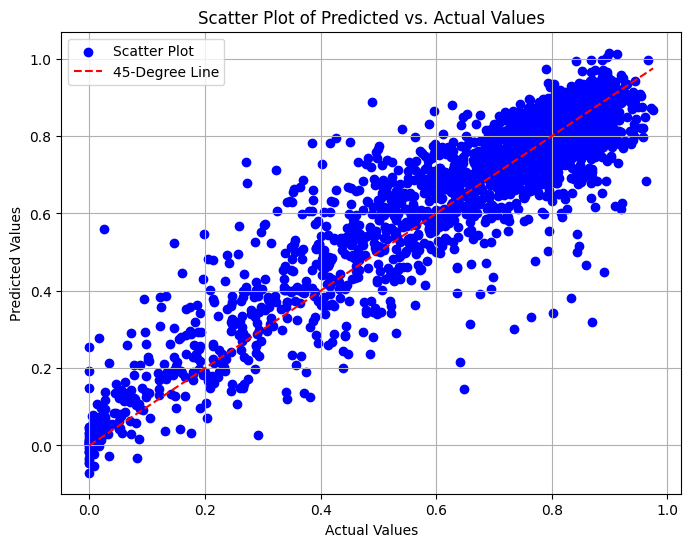

In [8]:
import matplotlib.pyplot as plt

# Assuming you have y_pred and y_test_actual defined earlier

# Extract the values from the Pandas DataFrame
y_actual_values = y_test_actual

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(y_actual_values, y_test_pred, c='blue', marker='o', label='Scatter Plot')

# Add labels and a 45-degree line for reference
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_actual_values), max(y_actual_values)], [min(y_actual_values), max(y_actual_values)], ls='--', c='red', label='45-Degree Line')

# Add a legend
plt.legend()

# Set plot title
plt.title('Scatter Plot of Predicted vs. Actual Values')

# Show the plot
plt.grid(True)
plt.show()


In [9]:
from sklearn.metrics import r2_score

# Calculate the R-squared score
r2 = r2_score(y_actual_values, y_test_pred)

# Print the R-squared score
print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.8488381619460579


In [10]:
# Assuming y_test_pred is a NumPy array
y_test_pred = y_test_pred.reshape(-1)

# Now both arrays should have the same shape
data = np.array([y_actual_values, y_test_pred])

# Calculate correlation coefficient matrix
corr_matrix = np.corrcoef(data)

In [11]:
import numpy as np
from scipy.stats import pearsonr

# Assuming y_test_pred is a NumPy array
y_test_pred = y_test_pred.reshape(-1)

# Calculate Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(y_actual_values, y_test_pred)

print("Pearson Correlation Coefficient:", correlation_coefficient)
print("P-value:", p_value)

Pearson Correlation Coefficient: 0.9228275621098139
P-value: 0.0


In [12]:
from scipy.stats import spearmanr

# Calculate Spearman correlation coefficient
spearman_coefficient, p_value_spearman = spearmanr(y_actual_values, y_test_pred)

print("Spearman Correlation Coefficient:", spearman_coefficient)
print("P-value (Spearman):", p_value_spearman)

Spearman Correlation Coefficient: 0.8557279096958716
P-value (Spearman): 0.0
